![MIoT_GDPI](img/MIOT_GDPI_header.png)

# Unidad 05 - Introducción a las Redes Neuronales Recurrentes (RNN)
Típicamente, las plantas industriales cuentan con **líneas de producción secuenciales en las que los procesos son altamente no lineales y tienen grandes dependencias temporales**. Como consecuencia, los modelos predictivos que no tienen en cuenta el tiempo, suelen ser poco apropiados. En esta práctica introduciremos las **Redes Neuronales Recurrentes** (RNNs) como **sistemas capaces de modelar procesos en los que se tiene en cuenta el histórico de las observaciones** para poder predecir con precisión. 



La mayor parte del contenido de este Notebook se dedica a explicar la adaptación de los datos y el uso del API Keras para generar y utilizar RNNs. Es crucial que dediquéis tiempo a leer y comprender el material, en lugar de simplemente ejecutar el código. Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en cada uno de los conceptos mostrados. **Este es un Notebook especialmente indicado para probar cosas**.



**Importante**: El Notebook contiene un ejercicio sencillo que deberéis desarrollar durante la clase y enviarlo por el aula virtual del curso a través de la tarea correspondiente. 




## Referencias útiles para la práctica

1. [Documentación oficial](https://www.tensorflow.org/learn?hl=es-419) de Tensorflow
2. [Guías](https://keras.io/guides/) de Keras
3. [Vídeo](https://www.youtube.com/watch?v=AsNTP8Kwu80 ) intuitivo y ameno sobre las RNNs
4. A. Bosch Rué, J. Casas-Roma, T. Lozano Bagén (2019): [Deep learning : principios y fundamentos](https://elibro-net.ezbusc.usc.gal/es/ereader/busc/126167/).




## 1. Redes Neuronales Recurrentes
En el ámbito de la optimización y el análisis predictivo dentro de las líneas de producción industrial, nos encontramos a menudo con **procesos que no son estáticos**, sino que se desarrollan a lo largo del tiempo, donde **cada paso o estación influye en los siguientes**. La naturaleza secuencial de estas operaciones es fundamental: **el estado actual de un producto o del proceso mismo depende intrínsecamente de su historia previa**. Si intentamos aplicar modelos de aprendizaje automático que tratan cada punto de datos o cada instante como una observación independiente, sin tener en cuenta el orden o la dependencia temporal (como haríamos con modelos tradicionales que asumen independencia y distribución idéntica), estaremos ignorando información crucial. **Estos modelos no pueden "recordar"** lo que ocurrió antes, lo que los hace inadecuados para capturar patrones que se despliegan a lo largo de la secuencia de producción. Es aquí donde las RNNs cobran relevancia.
<div style="text-align: center;">
    <img src="img/observacionLinea.png" />

</div>
<p style="text-align:center; font-style:italic;">Una observación de una línea secuencial está capturando datos no relacionados, debido a los desplazamientos temporales.</p>




**La arquitectura inherente de las RNNs está diseñada para procesar secuencias y les permite mantener un estado interno que actúa como una memoria, incorporando información de pasos temporales anteriores para influir en el procesamiento del paso actual**. Esta capacidad de aprender y utilizar el contexto histórico las convierte en la herramienta perfecta para modelar las complejas dinámicas temporales de una línea de producción secuencial, permitiéndonos abordar tareas como la detección temprana de fallos que se desarrollan con el tiempo, la predicción de desvíos en variables de calidad teniendo en cuenta las observaciones históricas  o la optimización de parámetros en tiempo real considerando el impacto de ajustes pasados.


### 1.1 Concepto de recurrencia

Hasta ahora, en todas las ANN que habéis visto la información fluye siempre en una única dirección: desde las neuronas de entrada a las neuronas de salida. Son las ANN conocidas como *feedforward*, pero, en realidad, nada impide que haya conexiones desde una capa posterior a una anterior. Empleando esta particularidad podemos hacer que cuando la ANN procese una observación concreta, utilice también información que generó la red en un paso anterior a modo de memoria.  La figura mostrada a continuación muestra el esquema de una RNN simple compacta y desplegada. 


![MIoT_GDPI](img/RNNSimple.png)
<p style="text-align:center; font-style:italic;">Esquema de una RNN simple compacta y desplegada en 'n' instantes temporales.</p>

Las RNNs simples, en su forma más básica,  están formadas por una capa de entrada, una capa de recurrencia y una capa de salida. **La capa de recurrencia es la que almacena un estado interno o memoria que permite "recordar" los eventos pasados**. Al desplegar la RNN, cada iteración procesa una nueva observación de la secuencia. Cada observación procesada por la capa recurrente, tiene en cuenta los datos actuales y el estado interno generado por la observación anterior. Al inicio de la secuencia, el estado interno es 0.

La forma de calcular el estado interno/oculto en una RNN es:


$$h_t=f(x_t\cdot u+h_{t-1}\cdot v+b_h)$$



considerando que $h_0=0$ y siendo:

*  $f(\cdot)$ la función de activación que, normalmente, es $\tanh$ (en RNN simples).
* $h_t$ el estado interno actual.
* $h_{t-1}$ el estado interno del paso anterior.
* $u$ la matriz de pesos que conecta la capa de entrada ($x_t$) con la capa recurrente (para calcular $h_t$).
* $v$ la matriz de pesos que pondera el estado interno anterior ($h_{t−1}$) para el cálculo del estado interno actual $h_t$.
* $b_h$ el vector de sesgo (bias) de la capa recurrente.



Esta celda recurrente, se llama tantas veces como longitud tiene la serie temporal. Así, si la serie temporal tiene la forma:

$$\{x_1,x_2,x_3\}$$

los cálculos que se ejecutan son:

$$h_1=f(x_1\cdot u+h_{0}\cdot v+b_1)$$
$$h_2=f(x_2\cdot u+h_{1}\cdot v+b_h)$$
$$h_3=f(x_3^T\cdot u+h_{2}\cdot *v+b_h)$$
   
La salida generada sería la secuencia (*many-to-many*): $[h_1,h_2,h_3]$

o la última salida (*many-to-one*): $[h_3]$





Veremos durante las clases de teoría más detalles sobre este tipo de redes, pero entre las características interesantes cara a su uso en plantas industriales podemos destacar: 
* **La longitud de las secuencias no está limitada**. Una vez entrenadas pueden procesar secuencias de diferentes longitudes.
    * Aunque en la práctica se suele fijar un tamaño de la secuencia cara a un uso y entrenamiento efectivo.
* **Los pesos internos son compartidos para todas las iteraciones o pasos de la RNN**, independientemente de procesar secuencias mayores o menores.
    * Cuanto más despleguemos una RNN más dificil será entrenarla.
* Existen diferentes tipos de RNNs con **distintos tipos de celdas recurrentes**.
    * Las RNNs simples tienen un problema potencial de desvanecimiento/explosión de gradiente, que dificulta su uso si es necesario "recordar" relaciones muy distantes en el tiempo
    * Otro tipo de RNNs como las LSTMs o las GRUs, suelen ser más empleadas en la práctica por solucionar el problema del desvanecimiento/explosión del gradiente.
* Dependiendo de las entradas y salidas que queremos considerar, podemos emplear **diferentes tipos de arquitecturas** para las RNNs. Los principales son: 
  -  *many-to-many*.
  -   *one-to-many*.
  -   *many-to-one*.

**Nota**: Particularmente, en el control de procesos sobre líneas de producción secuenciales, la forma más típica es *many-to-one*. Una secuencia de operaciones es analizada con el objetivo de predecir algún tipo de variable de calidad final que ha sido influenciada por las operaciones previas.
<div style="text-align: center;">
<img src="img/RNNSimple_many_to_one.png" width="200"/>
</div>











In [1]:
# import generales
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np




try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

import os

# Asegurarnos de usar Keras 3 con backend TensorFlow
# Es necesario hacerlo antes de cargar Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importaciones de Keras y TensorFlow
try:
    import keras
except ImportError as err:
    !pip install keras
    import keras

try:
    import tensorflow as tf 
except ImportError as err:
    !pip install tensorflow
    import tensorflow as tf 



# Importaciones de Scikit-learn
#Solo para facilitarnos el uso de algunas operaciones típicas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Configuraciones para visualización. No es necesario
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráficos



# Verificación de versiones
#Existen diferentes versiones y compatibilidades. Es importantes saber lo que estamos ejecutando
#Para estos ejemplos queremos ejecutar el API de Keras3 (standalone) y tensorflo3>2.16
print(f"Versión de Keras: {keras.__version__}")
print(f"Backend de Keras: {keras.backend.backend()}")
print(f"Versión de TensorFlow: {tf.__version__}")



# Verificar si TensorFlow puede usar GPU en nuestro sistema (opcional, pero bueno saberlo)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU disponible: {gpu_devices}")
else:
    print("GPU no encontrada, se usará CPU.")


#Establecemos una semilla para todos los procesos en los que lo necesitemos
SEED=1234

print(f"la semilla que emplearemos para todos los procesos pseudoaleatorios es:{SEED}")

# Establece la semilla para los números aleatorios con  keras.utils.set_random_seed. Esto establecerá:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
#Permitir la reproducibilidad es clave para poder comparar
keras.utils.set_random_seed(SEED)

2025-05-17 17:48:41.002014: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 17:48:41.002519: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 17:48:41.005033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-17 17:48:41.011576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747496921.023072  373407 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747496921.02

Versión de Keras: 3.9.2
Backend de Keras: tensorflow
Versión de TensorFlow: 2.19.0
GPU no encontrada, se usará CPU.
la semilla que emplearemos para todos los procesos pseudoaleatorios es:1234


2025-05-17 17:48:42.384038: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Generación de un *dataset* sintético
Para poder probar las RNNs vamos a crear un dataset sintético  que imite una fábrica con una línea de producción  secuencial dividida en **5 secciones**. 

1.  **Sensores en cada sección:**
    * En cada sección, una máquina realiza una operación (ej: apretar un tornillo, calentar una pieza, etc.) y un sensor mide un parámetro clave de esa operación (ej: las revoluciones por minuto de un motor, la temperatura aplicada, etc.). Tendremos 5 series de datos, una por cada sensor de sección.
    * Cada sección puede influir en la siguiente; por ejemplo, si una máquina en la sección 2 trabajó muy rápido, la sección 3 podría tener que ajustarse ligeramente.

2.  **Variable de Calidad Final:**
    * Al final de toda la línea, se inspecciona el producto y se mide una **variable de calidad** (ej: la resistencia de una soldadura, la humedad interna, el perfil de densidad, etc).
    * Esta calidad final **NO depende solo de la última operación**. Más bien, es el resultado de una *combinación* de cómo se aplicaron los procesos previos en las diferentes secciones cuando ese producto pasó por ellas.
        * Por ejemplo, la calidad podría depender mucho de lo que hizo la máquina de la sección 1 cuando el producto estuvo allí (hace 5 "pasos de tiempo"), un poco de la sección 2 (hace 3 "pasos de tiempo"), y así sucesivamente. Algunas secciones podrían no influir nada en esta variable de calidad particular.


3.  **El Reto para la Red Neuronal:**
    * Nuestro DataFrame mostrará, para cada producto, las lecturas actuales de los 5 sensores y su calidad final.
    * La Red Neuronal Recurrente (RNN) recibirá secuencias de las lecturas de los sensores de varios productos consecutivos. Su tarea será **aprender y descubrir por sí misma cómo esas lecturas pasadas (y de qué secciones específicas y con qué "retraso") afectan a la calidad del siguiente producto**, sin que le digamos explícitamente "fíjate en la sección 1 de hace 5 pasos".

Este dataset nos permitirá simular un problema realista donde es necesario analizar secuencias temporales para predecir un resultado futuro que tiene dependencias complejas con el pasado.

In [2]:
# ## Generación de Datos Sintéticos (Línea de Producción Secuencial)

N_SAMPLES_FINAL = 20000 # Número de muestras finales en nuestro dataset
N_SECTIONS = 5 #secciones de nuestra línea de producción
SEQUENCE_LENGTH = 5 # Usaremos secuencias de 5 timesteps para predecir el siguiente.
EXTRA_LENGTH_TO_EXERCISE=0 #¡ESTA VARIABLE SOLO LA MODIFICARÉIS PARA DESARROLLAR EL EJERCICIO!!
SEQUENCE_LENGTH+=EXTRA_LENGTH_TO_EXERCISE
# Parámetros para la generación de datos de sensores por sección
# Lags (en pasos de tiempo para la contribución de cada sección a la calidad final.
# L_s = k significa que el valor del sensor de la sección 's' hace k observaciones afectó la calidad del producto actual.
# Ejemplo: L_s = 1 significa que P_{s, t-1} afecta a Q_t.
SECTION_LAGS = np.array([5, 4, 3, 2, 1]) # Lags para S1, S2, S3, S4, S5 respectivamente

SECTION_LAGS=SECTION_LAGS+EXTRA_LENGTH_TO_EXERCISE
print(SECTION_LAGS)

L_max = np.max(SECTION_LAGS) if len(SECTION_LAGS) > 0 else 0

# Necesitamos generar más datos al principio para acomodar los retardos máximos.
N_RAW_SAMPLES = N_SAMPLES_FINAL + L_max

# Inicializar arrays para los valores de los sensores
P_raw = np.zeros((N_SECTIONS, N_RAW_SAMPLES))
time_raw = np.arange(N_RAW_SAMPLES)#pasos de tiempo

# Parámetros base para cada sección (amplitud, frecuencia, offset, ruido)
base_params_amplitude = [10, 8, 12, 7, 10]
base_params_period = [50, 180, 10, 70, 45]
base_params_offset = [100, 10, 120, 90, 110]
base_params_noise_std = [2, 1.5, 2, 1, 1.8]



# Sección 1 (S1) - Comportamiento base
P_raw[0, :] = (base_params_amplitude[0] * np.sin(time_raw / base_params_period[0])) +  base_params_offset[0] + \
                5 * np.cos(time_raw / 20) + np.random.randn(N_RAW_SAMPLES) * base_params_noise_std[0]

# Secciones 2 a 5 (S2-S5) - Influenciadas por la sección anterior
# Coeficientes de influencia de la sección anterior (pequeños)
alpha_influence = [0.15, -0.2, 0, 0.35] # Para S2 por S1, S3 por S2, etc.



for s in range(1, N_SECTIONS): # Para S2, S3, S4, S5
    influence_term = alpha_influence[s-1] * P_raw[s-1, :]#influencia de la sección anterior
    base_behavior = (base_params_amplitude[s-1] * np.sin(time_raw / base_params_period[s-1]) +
                     base_params_offset[s-1] +
                     np.random.randn(N_RAW_SAMPLES) * base_params_noise_std[s-1])#añadimos algo de ruido típico en los sensores
    P_raw[s, :] = influence_term + base_behavior#añadimos la influencia de la sección anterior






# Generación de la Variable de Calidad Final (Q_t)
#la variable de calidad está influenciada por el proceso 'n' hace 'k' pasos de tiempo definidos en SECTION_LAGS
# Q_t = f(P_{1,t-L1}, P_{2,t-L2}, P_{3,t-L3}, P_{4,t-L4}, P_{5,t-L5}) 
# Los pesos (w_s) indican la contribución de cada sección a la variable final (medida de hace 'k' pasos de tiempo). Algunos pueden ser cero.
quality_weights = np.array([2, 0.10, -3, 0.1, 0.1]) 


Q_raw = np.zeros(N_RAW_SAMPLES)
base_quality_offset = 0  #valor base de la variable de calidad al que se le añade el efecto de las otras secciones




#Generamos una variable de calidad con dependencias temporales con un comportamiento lineal. 
#Se podría complicar más añadiendo dependencias no lineales y ruido
#Recordad que las redes RNN simples tienen sus limitaciones

for t in range(L_max, N_RAW_SAMPLES):   
    Q_raw[t] = base_quality_offset
    for i in range(N_SECTIONS):
        Q_raw[t] += quality_weights[i] * P_raw[0, t - SECTION_LAGS[i]] #podríamos crear un comportamiento lineal
    
    
    
    

    
    
#Generamos un dataframe por comodidad

df_cols = {}
for s in range(N_SECTIONS):
    df_cols[f'Seccion_{s+1}'] = P_raw[s, L_max:]
df_cols['Calidad'] = Q_raw[L_max:]

data_df = pd.DataFrame(df_cols)
print(f"Estructura del dataset: {data_df.shape}")

print("\nPrimeras filas del dataset generado:")
print(data_df.head(n=10))








    

[15 14 13 12 11]
Estructura del dataset: (20000, 6)

Primeras filas del dataset generado:
    Seccion_1   Seccion_2  Seccion_3   Seccion_4   Seccion_5    Calidad
0  106.617883  119.697134 -13.819744  130.476163  136.937497 -81.636416
1  107.440106  118.977131 -10.844458  130.849060  137.567588 -77.119417
2  107.212971  117.786449 -17.346788  132.342083  138.144715 -64.271411
3  109.273109  118.602620 -14.992735  129.625820  136.235646 -81.338230
4  103.523809  119.186099 -13.209771  132.856706  140.539110 -82.695704
5  106.190402  122.051689 -12.311513  132.880282  138.584761 -67.650297
6  105.253521  118.917998 -12.717334  128.957950  136.138016 -71.773568
7  106.914218  119.618855 -11.724599  133.613110  139.226314 -63.449652
8  107.588796  123.536207 -13.739656  127.580446  137.659325 -81.699641
9  109.065884  117.903310 -13.049796  128.238791  138.206776 -89.712735


### 2.1. Exploración visual de los datos

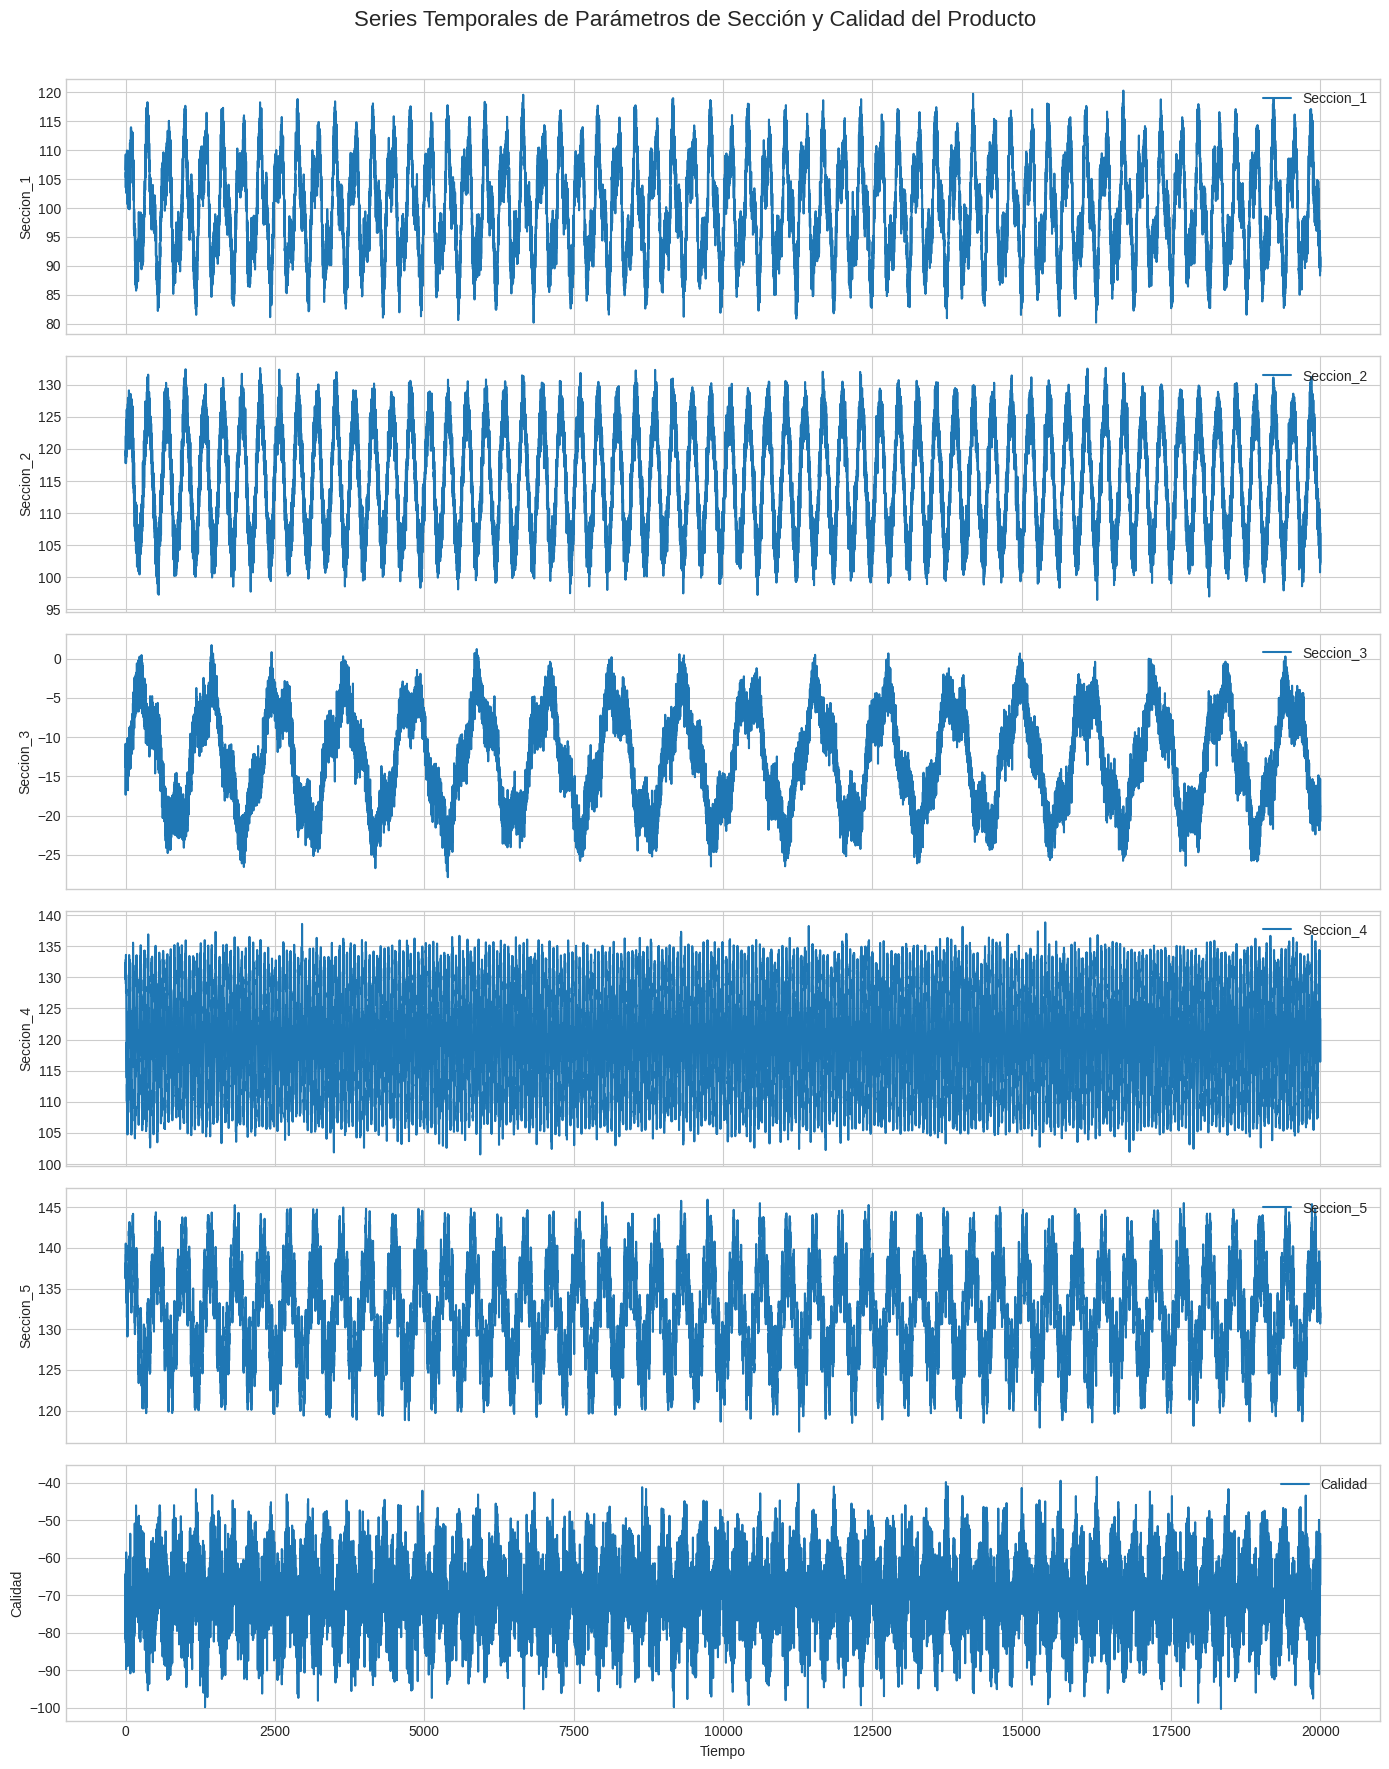

In [3]:
# Exploración y Visualización de Datos
# Visualizar las series temporales generadas para entender sus patrones.

fig, axs = plt.subplots(N_SECTIONS + 1, 1, figsize=(14, 18), sharex=True)
features_to_plot = [f'Seccion_{s+1}' for s in range(N_SECTIONS)] + ['Calidad']

for i, feature_name in enumerate(features_to_plot):
    axs[i].plot(data_df[feature_name], label=feature_name)
    axs[i].set_ylabel(feature_name)
    axs[i].legend(loc="upper right")
axs[-1].set_xlabel("Tiempo")
fig.suptitle("Series Temporales de Parámetros de Sección y Calidad del Producto", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 3. Preparación de los datos

La generacion, configuración y el entrenamiento de las RNNs lo realizaréis, habitualmente, con librerías especializadas como, por ejemplo Keras, por lo que  esa dificultad queda "externalizada". La parte, tipicamente, más compleja es el preprocesado y preparación de los datos. La parte de preprocesado es similar a la que nos podemos encontrar en cualquier desarrollo de modelos de aprendizaje automática PERO debemos tener en cuenta las dependencias temporales intrínsicas de los datos a la hora de realizar operaciones. En este caso tan simplificado, simplemente realizaremos una estandarización de los entradas.

### 3.1 División de los datos (entrenamiento, validación y test)


**La división de los datos entre entrenamiento, validación y test SÍ que es necesario planteársela cuidadosamente** cuando se trabaja en plantas industriales en general y en particular cuando existen dependencias temporales.

**IMPORTANTE**: *Los siguientes comentarios surgen del uso práctico de RNNs en entornos de factorías reales. Consultad cualquier duda respecto a ellos*.


* La típica **división aleatoria no podemos hacerla directamente, ya que perderíamos las dependencias temporales**.
* Si repartimos los **datos secuencialmente** no perderíamos las dependencias temporales pero puede ser **problemático** si el caso de uso  que estamos modelando está afectado por **estacionalidades**.
    - *Imaginad la situación en que se entrena con datos de invierno y se testea con datos de verano. Si el problema está afectado por estacionalidades, el modelo no habrá generalizado correctamente*.

* En caso de generar un **dataset formado por secuencias** (agrupando observaciones para no perder las dependencias temporales), en lugar de observaciones independientes, podríamos **repartir aleatoriamente las secuencias para no tener problemas con la estacionalidad a la vez que mantenemos las dependencias temporales PERO** debemos tener en cuenta varias situaciones:
1. Típicamente, en las líneas de procesamiento, **el proceso cambia de forma suave. No existen grandes saltos del instante $t$ al $t+1$**, eso tiene como consecuencia que si las secuencias se reparten completamente aleatorias, caeran en el conjunto de validación secuencias muy parecidas a las que están en entrenamiento, generando métricas muy optimistas, ya que la validación mejora al mismo ritmo que el entrenamiento. Este problema no ocurre si las secuencias se reparte de forma secuencial.
    * Una opción para evitar este problema es "alejar" las secuencias unas de otras. Forzar a que exista un mínimo de pasos temporales entre secuencias.
    * Otra opción es generar pequeños lotes secuencias repartidos aleatoriamente por el dataset.
     ![MIoT_GDPI](img/reparto_aleatorio_lotes.png)
<p style="text-align:center; font-style:italic;">Reparto aleatorio de lotes secuenciales para evitar perder las dependencias temporales y solucionar el problema de la estacionalidad.</p>

2. **¿Las secuencias se generan con solape o sin solape?** (problema intimamente relacionado con el anterior) Si se generan con solape tendremos muchas secuencias muy parecidas y podemos caer facilmente en un sobreentrenamiento. **En general, mi recomendación es emplear solape en los conjuntos de prueba**, para poder ver la evolución en el tiempo, **y sin solape en el entrenamiento.**

|                                               |
| -------------------------------------------- |
| $$s_1=\{x_i,x_{i+1},...,x_{n-1},x_{n}\}$$ |
|$$s_2=\{x_{i+1},x_{i+2},...,x_{n},x_{n+1}\}$$|
| *Ejemplo de 2 secuencias solapadas.* |


|                                               |
| -------------------------------------------- |
| $$s_1=\{x_i,x_{i+1},...,x_{n-1},x_{n}\}$$ |
|$$s_2=\{x_{i+1},x_{i+2},...,x_{n},x_{n+1}\}$$|
| *Ejemplo de 2 secuencias sin solape.* |








El problema que estamos modelando en este ejemplo **no tienen problemas de estacionalidad**, por lo que vamos a repartir los datos en secuencias (para no perder las dependencias temporales) y, a continuación, generaremos las secuencias para unir las observaciones.


In [4]:
def separar_inputs_outputs(dataset):
    """Separa un DataFrame de Pandas en características (inputs) y la columna objetivo 'Calidad'.
    Args:
        dataset (pd.DataFrame): El DataFrame de Pandas que se va a procesar.
            Se espera que este DataFrame contenga las características de entrada
            y, potencialmente, la columna objetivo 'Calidad'.

    Returns:
          Una tupla con dos elementos:
            1. inputs (pd.DataFrame | None): Un DataFrame con las características
               (todas las columnas del dataset original excepto 'Calidad').
               Retorna `None` si la columna 'Calidad' no se encuentra en el
               `dataset`.
            2. outputs (pd.Series | None): Una Serie de Pandas con la columna
               'Calidad'. Retorna `None` si la columna 'Calidad' no se
               encuentra en el `dataset`.
    """
    if 'Calidad' in dataset.columns: 
        return dataset.drop('Calidad', axis=1), dataset['Calidad']
    else: return None, None

def separar_conjuntos(dataset, perc_entrenamiento=0.7):
    """Divide un conjunto de datos secuencial en entrenamiento, validación y prueba.
    - El conjunto de entrenamiento obtiene `perc_entrenamiento` del total de muestras.
    - El porcentaje restante, `(1 - perc_entrenamiento)`, se divide equitativamente
      entre los conjuntos de validación y prueba.
    Args:
        dataset: El conjunto de datos completo a dividir.
        perc_entrenamiento (float, optional): Proporción del dataset a asignar al
            conjunto de entrenamiento. 

    Returns:
        Tuple[Sequence, Sequence, Sequence]: Una tupla con tres subconjuntos de datos:
            1. El subconjunto de entrenamiento.
            2. El subconjunto de validación.
            3. El subconjunto de prueba.
    """
    perc_entrenamiento=perc_entrenamiento if 0<perc_entrenamiento<1 else 0.7
    
    num_train_samples = int(perc_entrenamiento * len(dataset))
    num_val_samples =int((1-perc_entrenamiento)/2 * len(dataset))
    num_test_samples = len(dataset) - num_train_samples - num_val_samples
    return dataset[:num_train_samples], \
            dataset[num_train_samples : num_train_samples + num_val_samples],\
            dataset[num_train_samples + num_val_samples:]
    
#Dependiendo la estrategia deberemos crear las secuencias antes o después del reparto    
#separamos en 3 conjuntos en base al porcentaje de entrenamiento
train_set, val_set, test_set=separar_conjuntos(data_df,perc_entrenamiento=0.7)

#separamos los conjuntos en inputs y outputs
#podría haberse realizado todo desde la misma función
train_features, train_targets=separar_inputs_outputs(train_set)
val_features, val_targets=separar_inputs_outputs(val_set)
test_features, test_targets=separar_inputs_outputs(test_set)

print(f"Estructura de entrenamiento (features): {train_features.shape}")
print(f"Estructura de entrenamiento (outputs): {train_targets.shape}")

print(f"Estructura de validación (features): {val_features.shape}")
print(f"Estructura de validación (outputs): {val_targets.shape}")

print(f"Estructura de test (features): {test_features.shape}")
print(f"Estructura de test (outputs): {test_targets.shape}")



Estructura de entrenamiento (features): (14000, 5)
Estructura de entrenamiento (outputs): (14000,)
Estructura de validación (features): (3000, 5)
Estructura de validación (outputs): (3000,)
Estructura de test (features): (3000, 5)
Estructura de test (outputs): (3000,)



### 3.2 Estandarización de los datos con Keras


En lugar de estandarizar los datos a través de una operación de `scikit-learn` (sistema que ya conocéis), lo haremos desde el propio Keras generando una [capa de preprocesado](https://keras.io/api/layers/preprocessing_layers/). Esto tiene como ventaja poder incluirlo en el propio modelo y que este sea autosuficiente. Debéis de recordar que el entrenamiento de los modelos es solo la primera fase, luego es necesario desplegarlos en producción y trabajar con ellos. Poder guardar con el modelo toda la información necesaria para poder emplearlo (ej. capa de estandarización), simplifica su empleo.

In [5]:
# Estandarización de las características de entrada

normalization_layer = keras.layers.Normalization(axis=-1)
normalization_layer.adapt(train_features.values) # ajustar SOLO con datos de entrenamiento las características de entrada


## 3.2 Preparación de las secuencias de datos
Para poder  entrenar modelos recurrentes es necesario crear  las secuencias que vamos a emplear para entrenarlos. Aunque las RNNs pueden soportar secuencias de diferentes tamaños, lo habitual es fijar un tamaño $k$, para poder entrenarlos de forma eficiente.

Generar las secuencias para los modelos RNN de keras implica preparar los datos de forma que se generen tensores de la forma `(batch_size, timesteps, features)`:
* `batch_size` (tamaño del lote): Es el número de secuencias que se procesan simultáneamente en una pasada de entrenamiento.
* `timesteps` (pasos de tiempo o longitud de la secuencia): Es el número de observaciones consecutivas en cada secuencia individual que se van a emplear para entrenar.
* `features` (características): Es el número de variables o características que observas en cada paso de tiempo.

Aunque se puede realizar a mano, para preparar las secuencias respecto a nuestros *datasets* emplearemos [keras.utils.timeseries_dataset_from_array](https://keras.io/api/data_loading/timeseries/), ya que facilita el desarrollo de los tensores. Su principal objetivo es facilitar la preparación de datos para modelos que aprenden de secuencias, como las RNNs simples, LSTMs, GRUs o Transformers, cuando se trabaja con datos de series temporales.



Importante tener claro cómo se le pasan los datos a `keras.utils.timeseries_dataset_from_array` ([ver ejemplo 2 manual](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)).

*Considera un array data de valores escalares, con forma (*steps*,). Para generar un conjunto de datos que utilice los k pasos de tiempo anteriores para predecir el siguiente paso de tiempo, usarías:*

<code>
k=10
input_data = data[:-k]
targets = data[k:]
dataset = timeseries_dataset_from_array(input_data, targets, sequence_length=k)
</code>



In [6]:

# **Creación de Secuencias (Ventanas de Tiempo)**
# empleando `tf.keras.utils.timeseries_dataset_from_array`.
# el formato generado es (batch_size, timesteps, features)


#para generar la salida del instante 't+1' 
#necesitamos la secuencia [i:i+SEQUENCE_LENGTH-1]
#x[i], ..., x[i + SEQUENCE_LENGTH - 1] es la secuencia que termina en el instante t = i + SEQUENCE_LENGTH - 1)
# se usa para predecir y[i + sequence_length] (que es el valor del objetivo en t+1).




def generacion_secuencias_temporales(features, targets, seq_len, solape=False, shuffle=True):
    BATCH_SIZE = 32    
    seq_stride=1 if  solape else seq_len

    return  keras.utils.timeseries_dataset_from_array(
        data=features,
        targets=targets,
        sequence_length=seq_len,
        sequence_stride= seq_stride,#importante decidir si queremos o no secuencias con solape
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
)



#preparamos los datos a pasar (fijaos en la explicación anterior. SEQUENCE_LENGTH=k)
train_features_rnn=train_features[:-SEQUENCE_LENGTH]
val_features_rnn=val_features[:-SEQUENCE_LENGTH]
test_features_rnn=test_features[:-SEQUENCE_LENGTH]
train_targets_rnn=train_targets[SEQUENCE_LENGTH:]
val_targets_rnn=val_targets[SEQUENCE_LENGTH:]
test_targets_rnn=test_targets[SEQUENCE_LENGTH:]

#genemos los datasets con secuencias
train_dataset=generacion_secuencias_temporales(train_features_rnn, train_targets_rnn, solape=False, seq_len=SEQUENCE_LENGTH,shuffle=False)
val_dataset=generacion_secuencias_temporales(val_features_rnn, val_targets_rnn, solape=True, seq_len=SEQUENCE_LENGTH, shuffle=False)
test_dataset=generacion_secuencias_temporales(test_features_rnn, test_targets_rnn, solape=True,  seq_len=SEQUENCE_LENGTH, shuffle=False)



print("\nInspección de un batch del dataset de entrenamiento:")
for batch_inputs, batch_targets in train_dataset.take(1):
    print("Forma de las entradas del lote (batch_inputs):", batch_inputs.shape) # (BATCH_SIZE, SEQUENCE_LENGTH, N_SECTIONS)
    print("Forma de las etiquetas del lote (batch_targets):", batch_targets.shape) # (BATCH_SIZE,)
    print("\nVisualización de un elemento (inputs):")
    print("\nVisualización de un elemento (outputs):")
    print(batch_inputs[0])
    print(batch_targets[0])


#comprobamos que hemos ajustado bien las entradas y las salidas
for batch in train_dataset:
  inputs, targets = batch
  assert np.array_equal(inputs[0], train_features[:SEQUENCE_LENGTH])  # First sequence: steps [0-SEQUENCE_LENGTH]
  assert np.array_equal(targets[0], train_targets[SEQUENCE_LENGTH])
  break

print(f"\nBatches de entrenamiento: {len(train_dataset)}")
print(f"Batches de validación: {len(val_dataset)}")
print(f"Batches de test: {len(test_dataset)}")




Inspección de un batch del dataset de entrenamiento:
Forma de las entradas del lote (batch_inputs): (32, 15, 5)
Forma de las etiquetas del lote (batch_targets): (32,)

Visualización de un elemento (inputs):

Visualización de un elemento (outputs):
tf.Tensor(
[[106.61788314 119.69713361 -13.81974361 130.47616262 136.93749663]
 [107.44010598 118.9771314  -10.84445765 130.84905954 137.56758813]
 [107.21297053 117.7864492  -17.34678761 132.34208319 138.14471539]
 [109.27310856 118.60262009 -14.99273537 129.62581975 136.23564633]
 [103.52380903 119.18609908 -13.20977125 132.85670583 140.53910988]
 [106.1904023  122.05168922 -12.31151335 132.88028152 138.58476067]
 [105.25352108 118.91799771 -12.71733351 128.95795021 136.13801638]
 [106.91421801 119.6188555  -11.72459886 133.6131096  139.22631377]
 [107.5887961  123.53620731 -13.73965576 127.58044604 137.65932501]
 [109.06588364 117.90330956 -13.04979631 128.23879142 138.20677605]
 [105.43225663 120.68276603 -13.09975362 128.2835965  137.93

2025-05-17 17:48:43.285921: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Definición del modelo 

Desarrollaremos un modelo simple RNN con una capa de entrada, una oculta RNN y una densa de salida. 

In [7]:
# Definición del Modelo RNN
# Modelo secuencial con: Input, Normalization, SimpleRNN, Dense (salida).
#Si type_rnn=False, generaría un modelo denso feedforward

def get_model(seq_len, num_model_features, preprocesing_layers, name_model, type_rnn=True):
    hidden_units=64


    #input layer
    model = keras.Sequential(name=name_model)

    shape=(seq_len, num_model_features) if type_rnn else (num_model_features, )
    model.add( keras.Input(shape=shape, name="input_layer"))
 
    #preprocesing layers
    for layer in preprocesing_layers:
       model.add(layer)

    #Hidden layer
    hidden_layer= keras.layers.SimpleRNN(units=hidden_units, activation='tanh', name="hidden_layer") if type_rnn \
                                    else keras.layers.Dense(hidden_units, activation='tanh', name="hidden_layer")

    model.add(hidden_layer)
    model.add( keras.layers.Dense(units=1,  activation='linear', name="output"))

    return model

In [8]:
rnn_model=get_model(SEQUENCE_LENGTH, N_SECTIONS, [normalization_layer], "rnn_model", type_rnn=True)
rnn_model.summary()
modelo_reseteado=True #para gestionar si el modelo se reentrena desde cero o desde un entreno previo

Model: "rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 15, 5)          │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (GRU)              │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,708 (53.55 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 11 (48.00 B)

### 4. Compilación del modelo


Antes de entrenar, necesitamos "compilar" el modelo para configurar su proceso de entrenamiento. Esto implica definir:

* **Optimizador**: Algoritmo que ajusta los pesos de la red durante el entrenamiento (ej. Adam, SGD, RMSprop). Adam es una opción robusta y popular. Tenéis [aquí](https://keras.io/api/optimizers/) un listado de los disponibles. La configuración de los parámetros del optimizador sería algo para optimizar en la búsqueda hiperparamétrica.

* **Función de Pérdida** (*Loss Function*): Mide qué tan bien se desempeña el modelo durante el entrenamiento. Para regresión, mean_squared_error (MSE) es una opción muy típica. Tenéis [otras](https://keras.io/api/losses/) disponibles.


* **Métricas**: Funciones para evaluar el rendimiento del modelo (ej. mean_absolute_error - MAE). **Las métricas no se usan para optimizar el modelo, solo para monitorizarlo**. Tenéis [aquí](https://keras.io/api/metrics/) un listado de las disponibles

In [9]:
# Compilación del Modelo
# Optimizador Adam, pérdida MSE, métrica MAE.

rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)




### 5. Entrenamiento del modelo

Ya tenemos definido y configurado el modelo para poder entrenarse con nuestro  dataset de entrada. Recordad que el **modelo contiene una capa de normalización**, por lo que **los datos que se le pasen para entrenar NO pueden estar normalizados** ( lo hará el propio modelo).


El método `fit` es el empleado para entrenar. Tenéis [aquí](https://keras.io/api/models/model_training_apis/#fit-method) disponible todos los parámetros posibles. En este caso emplearemos:

* **epochs**: Número de veces que el modelo verá el conjunto de datos completo.
* **batch_size**: Número de muestras procesadas antes de actualizar los pesos (entrenamiento con *mini-batches*).
* **validation_data**: conjunto de datos sobre los que validaremos el entrenamiento del modelo. Lo podemos emplear para comparar configuraciones o para parar el entrenamiento de forma prematura (*early_stopping*), lo que puede ayudar a detectar el *overfitting*.

El método `fit` devuelve un objeto *History* que contiene información sobre el proceso de entrenamiento (pérdida y métricas en cada época) que podremos utilizar posteriormente para graficar el proceso de entreno y poder valorar si tenemos *overfitting* o *underfitting*.

En este caso definiremos un *callback* que permita parar el entrenamiento cuando las métricas sobre el conjunto de validación dejen de mejorar y nos quedamos con el mejor modelo visto.

**IMPORTANTE**: cada vez que ejecutéis el entrenamiento, el modelo parte de su último estado. Si queréis volver a entrenarlo desde cero, entonces tenéis que volver a crearlo.

In [10]:
# Entrenamiento del Modelo
EPOCHS = 1000 # Aumentamos un poco por la posible mayor complejidad
# Considerar EarlyStopping en una implementación real.

if not modelo_reseteado:
    print("IMPORTANTE: el modelo se está reentrenando sin resetear!!!!")
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Número de épocas sin mejora antes de detener
    restore_best_weights=True # Restaurar los pesos del modelo de la mejor época
)

rnn_history = rnn_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[callback_early_stopping] # Añadimos el callback
)
modelo_reseteado=False




Epoch 1/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4955.6938 - mean_absolute_error: 69.8172 - val_loss: 4839.4609 - val_mean_absolute_error: 68.9879
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4596.3672 - mean_absolute_error: 67.2019 - val_loss: 3435.5896 - val_mean_absolute_error: 57.8921
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3343.0732 - mean_absolute_error: 57.1096 - val_loss: 3080.4731 - val_mean_absolute_error: 54.7407
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3017.1677 - mean_absolute_error: 54.1853 - val_loss: 2811.3323 - val_mean_absolute_error: 52.2246
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2758.3774 - mean_absolute_error: 51.7433 - val_loss: 2580.0837 - val_mean_absolute_error: 49.9616
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2533.3391 - mean_absolute_error: 49.5217 - val_loss: 2373.3086 - val_mean_absolute_error: 47.8475
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

### 6.  Evaluación del Modelo

Una vez entrenado el modelo, tenemos que evaluar su rendimento. Lo haremos desde dos puntos de vista:

1. **Visualizando el historial de entrenamiento**: Graficaremos la pérdida y la/s métrica/s disponibles (el MAE en este caso) tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas. Esto nos ayuda a diagnosticar problemas como el *overfitting* (cuando la pérdida de validación empieza a aumentar mientras la de entrenamiento sigue bajando) o el *underfitting* (cuando ambas pérdidas son muy altas).
2. **Evaluando en el conjunto de Test**: Usaremos el método `evaluate` con los datos de Test, que el modelo nunca ha visto, para generar la  estimación final e imparcial del rendimiento del modelo.

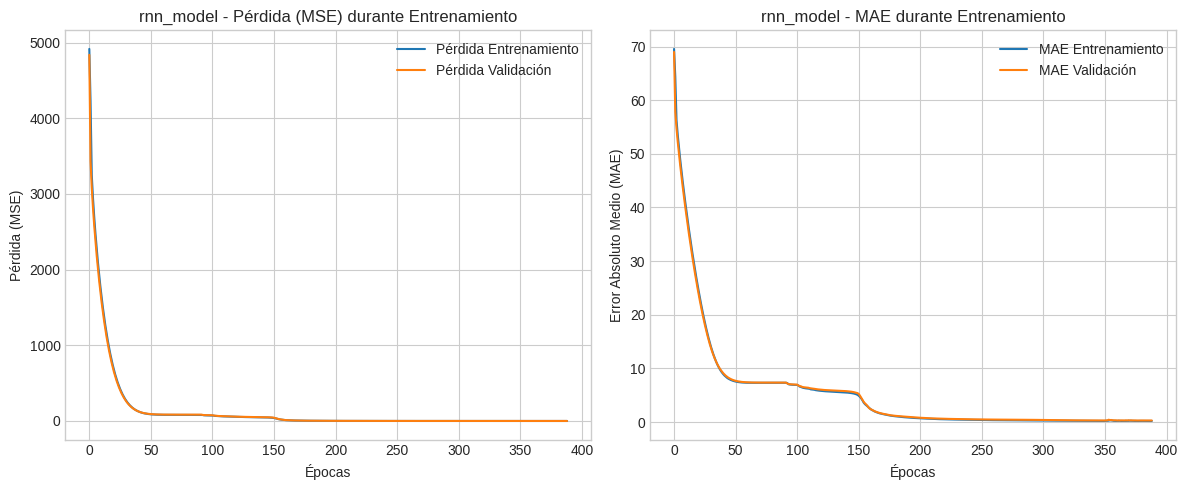

In [11]:
def graficas_entrenamiento(history, model_name=""):
    """Genera y muestra gráficos de pérdida y MAE del entrenamiento de un modelo Keras.

    Esta función toma un objeto `History` de Keras (devuelto por el método `fit()`)
    y grafica dos subplots:
    1.  La pérdida de entrenamiento ('loss') y la pérdida de validación ('val_loss')
        contra el número de épocas.
    2.  El MAE de entrenamiento  y el MAE de validación contra el número de épocas.

    Args:
        history_obj (keras.callbacks.History): El objeto `History` que Keras
            retorna después de entrenar un modelo con `model.fit()`.
        model_name: nombre del modelo que generó los datos históricos de entrenamiento
    """      
    
    hist=pd.DataFrame(history.history)
    #hist['epoch'] = hist.epoch
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot( hist['loss'], label='Pérdida Entrenamiento')
    plt.plot( hist['val_loss'], label = 'Pérdida Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')
    plt.title(f'{model_name} - Pérdida (MSE) durante Entrenamiento')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Asegúrate de usar el nombre correcto de la métrica (puede variar ligeramente)
    mae_key = 'mae' if 'mae' in hist.columns else list(hist.columns)[1] # Intenta encontrar la clave MAE
    val_mae_key = 'val_' + mae_key
    plt.plot(hist[mae_key], label='MAE Entrenamiento')
    plt.plot( hist[val_mae_key], label = 'MAE Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Error Absoluto Medio (MAE)')
    plt.title(f'{model_name} - MAE durante Entrenamiento')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#Graficar el entrenamiento por épocas. Ayuda a valorar el posible (sobre/infra)entrenamiento

graficas_entrenamiento(rnn_history, model_name=rnn_model.name)


Metricas del modelo: rnn_model
rnn_model - Pérdida (MSE) en Test: 0.1847
rnn_model - Error Absoluto Medio (MAE) en Test: 0.2875
Comparativa del modelo: rnn_model
[-66.3059979  -67.38134737 -82.86379797 -72.40969995 -64.83557911
 -83.22556504 -78.89617562 -76.72153804 -67.75998475 -59.74038788]


2025-05-17 17:52:09.284946: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


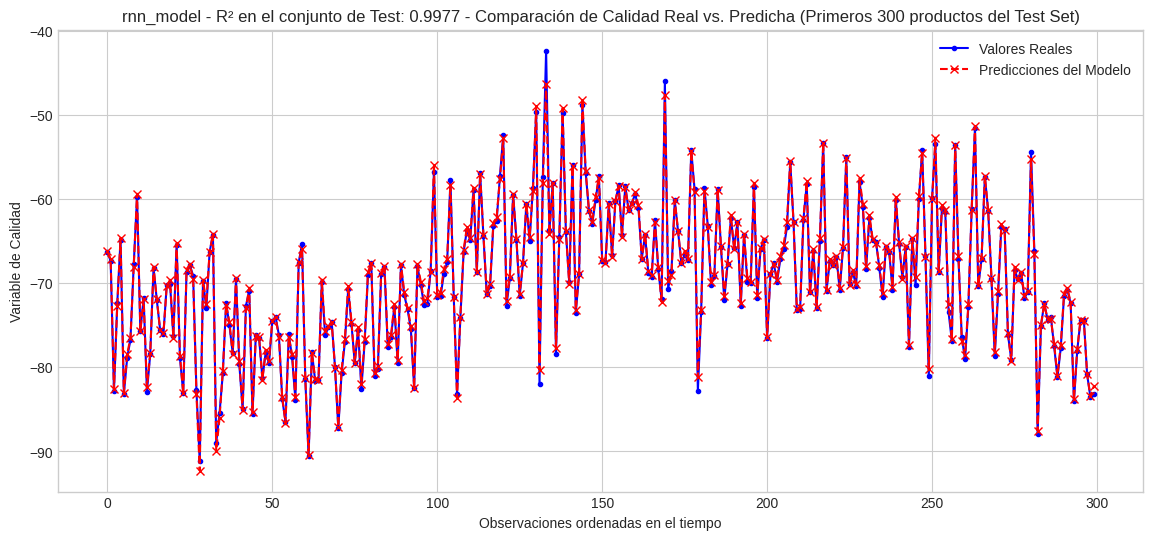

In [12]:
def print_test_metrics(model, test_dataset, targets=None):
    
    print(f"Metricas del modelo: {model.name}")
    if targets is None: #se pasan los datos como un dataset de tensorflow con inputs y ouputs juntos (secuencias)
        test_loss, test_mae = model.evaluate(test_dataset, verbose=0)#para las redes recurrentes
    else:
        test_loss, test_mae = model.evaluate(test_dataset, targets,verbose=0)#para las redes densas
        
    print(f"{model.name} - Pérdida (MSE) en Test: {test_loss:.4f}")
    print(f"{model.name} - Error Absoluto Medio (MAE) en Test: {test_mae:.4f}")
    
def print_seq__pred_vs_real(model, test_dataset, targets=None):
    print(f"Comparativa del modelo: {model.name}")
    predictions = model.predict(test_dataset, verbose=0)

    if targets is None: 
        real_test=[batch_targets_test.numpy() for _, batch_targets_test in test_dataset]#devuelve una lista de lista. Los outputs están agrupados en batches de 32
        #print(f"numero de batches: {len(real_test)} - Elementos en el batch: {len(real_test[0])}")
        actual_real_test = np.concatenate(real_test)#contactenamos todas las listas dentro de la lista (numero de batches) en una sola lista
    else:
        actual_real_test=targets.reset_index()


    print(actual_real_test[:10])
    r2 = r2_score(actual_real_test, predictions)

    plot_range = min(300, len(actual_real_test))

    plt.figure(figsize=(14, 6))
    plt.plot(actual_real_test[:plot_range], label='Valores Reales ', color='blue', marker='.', linestyle='-')
    plt.plot(predictions[:plot_range, 0], label='Predicciones del Modelo', color='red', marker='x', linestyle='--')
    plt.title(f'{model.name} - R² en el conjunto de Test: {r2:.4f} - Comparación de Calidad Real vs. Predicha (Primeros {plot_range} productos del Test Set)')
    plt.xlabel('Observaciones ordenadas en el tiempo')
    plt.ylabel('Variable de Calidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    

print_test_metrics(rnn_model, test_dataset)
print_seq__pred_vs_real(rnn_model, test_dataset)



#### EJERCICIO PARA ENTREGAR EN EL AULA VIRTUAL

Vais a forzar el problema de las RNNs simples (desvanecimiento/exposión de gradiente). Para ello tenéis que hacer lo siguiente:
1. Asignar un valor a EXTRA_LENGTH_TO_EXERCISE para que genere secuencias y dependencias temporales mayores (ej. 10)
2. Ejecutaréis y compararéis las siguientes versiones del modelo:
    * Un modelo con una RNN simple con una función de activación `tanh`. Es el que puedes generar por defecto empleando las funciones existentes en este Notebook. Ese modelo no debería poder predecir correctamente al tener dependencias temporales tan alejadas.
    * Un modelo con una RNN simple con una función de activación `relu`. Esa función de activación debería mejorar el entrenamiento y atenuar el problema del desvanecimiento de gradiente. **Necesitaréis modificar la función `get_model` para poder crear modelos diferentes en base a algún parámetro y compararlos.**
    * Un modelo con una capa LSTM en lugar de la RNN simple y una función de activación `tanh`. Las LSTMs y las GRUs son los modelos RNN más empleados **Necesitaréis modificar la función `get_model` para poder crear modelos diferentes en base a algún parámetro y compararlos.**
    * Un modelo con una capa GRU en lugar de la RNN simple y una función de activación `tanh`. Las LSTMs y las GRUs son los modelos RNN más empleados. **Necesitaréis modificar la función `get_model` para poder crear modelos diferentes en base a algún parámetro y compararlos.**
3. Despues de ejecutar y comparar los modelos, cread una celda de texto en la que resumáis los resultados obtenidos.
    * Inclui incluir imágenes y métricas para apoyaros.
  


